In [1]:
import numpy as np
import csv
import math
import statistics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/michellezhao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
datafile = 'sachacks.csv'
game_dict = {}

with open(datafile, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = 1
    for row in spamreader:
        if first == 1:
            first = 0
            continue
        game_id = row[0]
        team = row[1]
        player_id = row[2]
        matchup_id = row[3]
        position = int(row[4])
        archetype = int(row[5])
        field_goal_percentage = float(row[6])
        three_point_percentage = float(row[7])
        if row[8] == '':
            three_ptrs = 0
        else:
            three_ptrs = int(row[8])
        rebounds = int(row[9])
        assists = int(row[10])
        steals = int(row[11])
        turnovers = int(row[12])
        blocks = int(row[13])
        points= int(row[14])
        
        if game_id not in game_dict:
            game_dict[game_id] = {}
            game_dict[game_id][team] = {}
            game_dict[game_id][team]['points'] = 0
            game_dict[game_id][team]['players'] = {}
            game_dict[game_id][team]['setup'] = [0,0,0,0,0]
            game_dict[game_id][team]['players'][player_id] = {}
            game_dict[game_id][team]['players'][player_id]['results'] = [field_goal_percentage,three_point_percentage,three_ptrs,rebounds,assists,steals,turnovers,blocks,points] 
            game_dict[game_id][team]['players'][player_id]['position'] = position
            game_dict[game_id][team]['players'][player_id]['archetype'] = archetype
            game_dict[game_id][team]['setup'][int(position)-1] = archetype
            game_dict[game_id][team]['points'] = game_dict[game_id][team]['points'] + int(points)
            #fgp, 3pp, 3p, reb, ass, st, to, b, pts
            
        elif game_id in game_dict:
            if team not in game_dict[game_id]:
                game_dict[game_id][team] = {}
                game_dict[game_id][team]['points'] = 0
                game_dict[game_id][team]['players'] = {}
                game_dict[game_id][team]['setup'] = [0,0,0,0,0]
                game_dict[game_id][team]['players'][player_id] = {}
                game_dict[game_id][team]['players'][player_id]['results'] = [field_goal_percentage,three_point_percentage,three_ptrs,rebounds,assists,steals,turnovers,blocks,points]
                game_dict[game_id][team]['players'][player_id]['position'] = position
                game_dict[game_id][team]['players'][player_id]['archetype'] = archetype
                game_dict[game_id][team]['setup'][int(position)-1] = archetype
                game_dict[game_id][team]['points'] = game_dict[game_id][team]['points'] + int(points)
            elif team in game_dict[game_id]:
                game_dict[game_id][team]['players'][player_id] = {}
                game_dict[game_id][team]['players'][player_id]['results'] = [field_goal_percentage,three_point_percentage,three_ptrs,rebounds,assists,steals,turnovers,blocks,points]
                game_dict[game_id][team]['players'][player_id]['position'] = position
                game_dict[game_id][team]['players'][player_id]['archetype'] = archetype
                game_dict[game_id][team]['setup'][int(position)-1] = archetype
                game_dict[game_id][team]['points'] = game_dict[game_id][team]['points'] + int(points)



In [40]:
for game in game_dict:
    teams = []
    pts = []
    for team in game_dict[game]:
        teams.append(team)
        pts.append(game_dict[game][team]['points'])
        
    if pts[0]>pts[1]:
        game_dict[game][teams[0]]['win'] = 1
        game_dict[game][teams[1]]['win'] = 0
        
    else:
        game_dict[game][teams[1]]['win'] = 1
        game_dict[game][teams[0]]['win'] = 0
        

In [41]:
game_dict

{'71218-kings': {'kings': {'players': {'Coleworld2k': {'archetype': 5,
     'position': 4,
     'results': [0.0, 0.0, 0, 1, 0, 0, 0, 0, 0]},
    'Mootyy': {'archetype': 2,
     'position': 5,
     'results': [0.82, 0.0, 0, 14, 1, 0, 0, 1, 30]},
    'Safiya4ya': {'archetype': 3,
     'position': 3,
     'results': [0.5, 0.5, 1, 0, 2, 0, 0, 0, 3]},
    'TimelyCook': {'archetype': 2,
     'position': 2,
     'results': [0.44, 0.67, 2, 1, 2, 0, 0, 0, 10]},
    'Worthingcolt': {'archetype': 4,
     'position': 1,
     'results': [0.4, 0.33, 1, 0, 13, 3, 4, 0, 17]}},
   'points': 60,
   'setup': [4, 2, 3, 5, 2],
   'win': 1},
  'warriors': {'players': {'Bsmoove': {'archetype': 2,
     'position': 3,
     'results': [0.5, 0.0, 0, 6, 4, 1, 4, 0, 6]},
    'Lykapro': {'archetype': 4,
     'position': 1,
     'results': [0.6, 0.67, 2, 0, 5, 3, 5, 0, 10]},
    'ShawnWin': {'archetype': 5,
     'position': 2,
     'results': [0.83, 1.0, 2, 2, 0, 0, 0, 0, 12]},
    'Type': {'archetype': 5,
     'pos

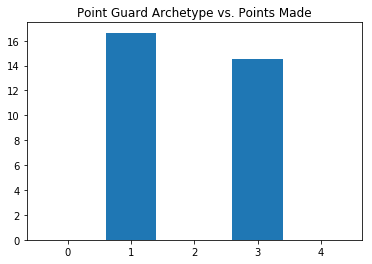

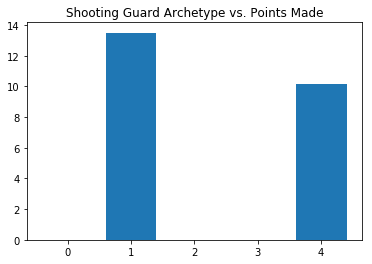

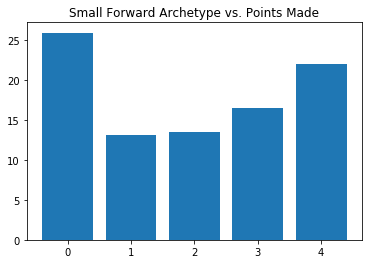

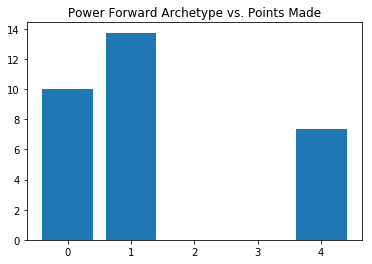

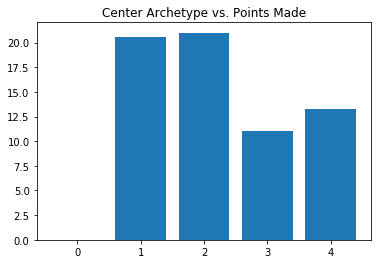

In [37]:
for i in range(1,6):
    pg_archs = range(5)
    pts_per_pg_archs = [[],[],[],[],[]]
    for game in game_dict:
        for team in game_dict[game]:
            for player in game_dict[game][team]['players']:
                results = game_dict[game][team]['players'][player]['results']
                pts = results[8]
                archetype = game_dict[game][team]['players'][player]['archetype']
                position = game_dict[game][team]['players'][player]['position']
                if position != i:
                    continue
                pts_per_pg_archs[archetype-1].append(pts)

    for pts in range(len(pts_per_pg_archs)):
        if pts_per_pg_archs[pts] == []:
            pts_per_pg_archs[pts] = 0
        else:
            pts_per_pg_archs[pts] = np.average(pts_per_pg_archs[pts])

    plt.bar(pg_archs, pts_per_pg_archs)
    if i == 1:
        plt.title("Point Guard Archetype vs. Points Made")
    if i == 2:
        plt.title("Shooting Guard Archetype vs. Points Made")
    if i == 3:
        plt.title("Small Forward Archetype vs. Points Made")
    if i == 4:
        plt.title("Power Forward Archetype vs. Points Made")
    if i == 5:
        plt.title("Center Archetype vs. Points Made")
    plt.show()

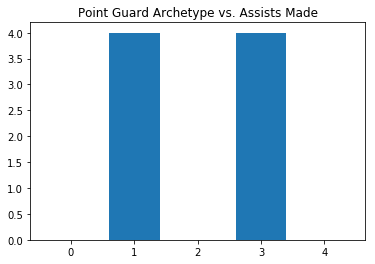

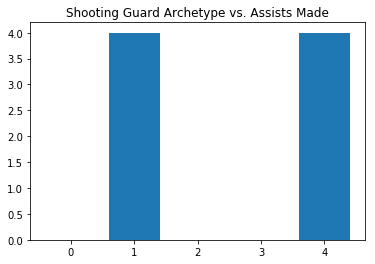

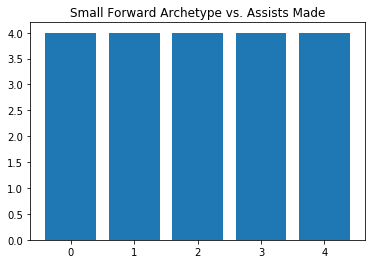

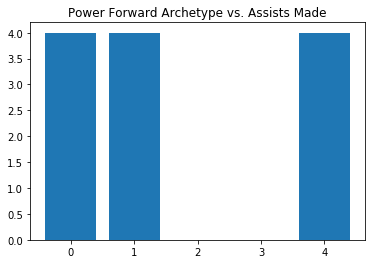

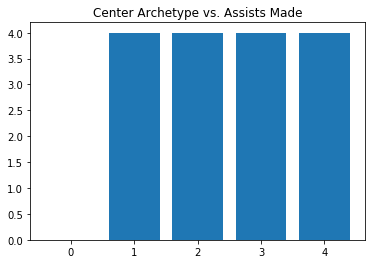

In [38]:
#fgp, 3pp, 3p, reb, ass, st, to, b, pts
for i in range(1,6):
    pg_archs = range(5)
    pts_per_pg_archs = [[],[],[],[],[]]
    for game in game_dict:
        for team in game_dict[game]:
            for player in game_dict[game][team]['players']:
                results = game_dict[game][team]['players'][player]['results']
                ass = results[4]
                archetype = game_dict[game][team]['players'][player]['archetype']
                position = game_dict[game][team]['players'][player]['position']
                if position != i:
                    continue
                pts_per_pg_archs[archetype-1].append(pts)

    for pts in range(len(pts_per_pg_archs)):
        if pts_per_pg_archs[pts] == []:
            pts_per_pg_archs[pts] = 0
        else:
            pts_per_pg_archs[pts] = np.average(pts_per_pg_archs[pts])

    plt.bar(pg_archs, pts_per_pg_archs)
    if i == 1:
        plt.title("Point Guard Archetype vs. Assists Made")
    if i == 2:
        plt.title("Shooting Guard Archetype vs. Assists Made")
    if i == 3:
        plt.title("Small Forward Archetype vs. Assists Made")
    if i == 4:
        plt.title("Power Forward Archetype vs. Assists Made")
    if i == 5:
        plt.title("Center Archetype vs. Assists Made")
    plt.show()

In [67]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
#     appX = []
#     appY = []
    for team in game_dict[game]:
        x = game_dict[game][team]['setup']
        X.append(x)
        y = game_dict[game][team]['win']
        Y.append(y)

# create model
X = np.array(X)
Y = np.array(Y)

model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
# model.add(Dense(12, activation='relu'))
# model.add(Dense(1, input_dim=12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=150, batch_size=10)
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
30/30 [==============================] - 1s 35ms/step - loss: 0.8283 - acc: 0.4667
Epoch 2/150
30/30 [==============================] - 0s 225us/step - loss: 0.8105 - acc: 0.4667
Epoch 3/150
30/30 [==============================] - 0s 179us/step - loss: 0.7964 - acc: 0.4667
Epoch 4/150
30/30 [==============================] - 0s 211us/step - loss: 0.7837 - acc: 0.4667
Epoch 5/150
30/30 [==============================] - 0s 183us/step - loss: 0.7710 - acc: 0.4667
Epoch 6/150
30/30 [==============================] - 0s 229us/step - loss: 0.7588 - acc: 0.5000
Epoch 7/150
30/30 [==============================] - 0s 219us/step - loss: 0.7524 - acc: 0.5333
Epoch 8/150
30/30 [==============================] - 0s 247us/step - loss: 0.7430 - acc: 0.5333
Epoch 9/150
30/30 [==============================] - 0s 237us/step - loss: 0.7338 - acc: 0.5000
Epoch 10/150
30/30 [==============================] - 0s 222us/step - loss: 0.7274 - acc: 0.5000
Epoch 11/150
30/30 [====================

30/30 [==============================] - 0s 203us/step - loss: 0.6701 - acc: 0.6000
Epoch 85/150
30/30 [==============================] - 0s 287us/step - loss: 0.6698 - acc: 0.6000
Epoch 86/150
30/30 [==============================] - 0s 204us/step - loss: 0.6693 - acc: 0.6000
Epoch 87/150
30/30 [==============================] - 0s 297us/step - loss: 0.6691 - acc: 0.6000
Epoch 88/150
30/30 [==============================] - 0s 197us/step - loss: 0.6685 - acc: 0.6000
Epoch 89/150
30/30 [==============================] - 0s 186us/step - loss: 0.6682 - acc: 0.6000
Epoch 90/150
30/30 [==============================] - 0s 252us/step - loss: 0.6681 - acc: 0.6000
Epoch 91/150
30/30 [==============================] - 0s 228us/step - loss: 0.6674 - acc: 0.6000
Epoch 92/150
30/30 [==============================] - 0s 174us/step - loss: 0.6672 - acc: 0.6000
Epoch 93/150
30/30 [==============================] - 0s 227us/step - loss: 0.6667 - acc: 0.6000
Epoch 94/150
30/30 [=======================

In [112]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    for team in game_dict[game]:
        setup = game_dict[game][team]['setup']
        x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for s in range(len(setup)):
            x[setup[s]+(5*s)-1]=1
        X.append(x)
        y = game_dict[game][team]['win']
        Y.append(y)

# trainX = X[:len(X)-5]
# trainY = Y[:len(Y)-5]
# testX = X[len(X)-5:]
# testY = Y[len(Y)-5:]
# create model
X = np.array(X)
Y = np.array(Y)

# testX = np.array(testX)
# testY = np.array(testY)

model = Sequential()
model.add(Dense(12, input_dim=25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=150, batch_size=3)
scores = model.evaluate(X,Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
30/30 [==============================] - 1s 25ms/step - loss: 0.7015 - acc: 0.5000
Epoch 2/150
30/30 [==============================] - 0s 522us/step - loss: 0.6943 - acc: 0.5333
Epoch 3/150
30/30 [==============================] - 0s 482us/step - loss: 0.6882 - acc: 0.5333
Epoch 4/150
30/30 [==============================] - 0s 506us/step - loss: 0.6818 - acc: 0.6667
Epoch 5/150
30/30 [==============================] - 0s 514us/step - loss: 0.6760 - acc: 0.6667
Epoch 6/150
30/30 [==============================] - 0s 506us/step - loss: 0.6712 - acc: 0.6667
Epoch 7/150
30/30 [==============================] - 0s 554us/step - loss: 0.6671 - acc: 0.6667
Epoch 8/150
30/30 [==============================] - 0s 512us/step - loss: 0.6605 - acc: 0.7000
Epoch 9/150
30/30 [==============================] - 0s 562us/step - loss: 0.6554 - acc: 0.7000
Epoch 10/150
30/30 [==============================] - 0s 522us/step - loss: 0.6519 - acc: 0.7000
Epoch 11/150
30/30 [====================

Epoch 84/150
30/30 [==============================] - 0s 525us/step - loss: 0.4720 - acc: 0.7667
Epoch 85/150
30/30 [==============================] - 0s 504us/step - loss: 0.4712 - acc: 0.7667
Epoch 86/150
30/30 [==============================] - 0s 485us/step - loss: 0.4687 - acc: 0.8000
Epoch 87/150
30/30 [==============================] - 0s 546us/step - loss: 0.4675 - acc: 0.8000
Epoch 88/150
30/30 [==============================] - 0s 509us/step - loss: 0.4659 - acc: 0.8000
Epoch 89/150
30/30 [==============================] - 0s 533us/step - loss: 0.4641 - acc: 0.8000
Epoch 90/150
30/30 [==============================] - 0s 535us/step - loss: 0.4640 - acc: 0.8000
Epoch 91/150
30/30 [==============================] - 0s 512us/step - loss: 0.4620 - acc: 0.8000
Epoch 92/150
30/30 [==============================] - 0s 504us/step - loss: 0.4601 - acc: 0.8000
Epoch 93/150
30/30 [==============================] - 0s 475us/step - loss: 0.4589 - acc: 0.8000
Epoch 94/150
30/30 [==========

In [113]:
model.predict(np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1]]))

array([[0.93522924]], dtype=float32)

In [105]:
X.shape

(25, 25)

In [230]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    team1 = list(game_dict[game].keys())[0]
    team2 = list(game_dict[game].keys())[1]
    if game_dict[game][team1]['win'] == 1:
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    

    loser_setup = game_dict[game][loser]['setup']
    x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(loser_setup)):
        x[loser_setup[s]+(5*s)-1]=1
    X.append(x)
    winner_setup = game_dict[game][winner]['setup']
    y = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(winner_setup)):
        y[winner_setup[s]+(5*s)-1]=1
    Y.append(y)

# trainX = X[:len(X)-5]
# trainY = Y[:len(Y)-5]
# testX = X[len(X)-5:]
# testY = Y[len(Y)-5:]
# create model
X = np.array(X)
Y = np.array(Y)

# testX = np.array(testX)
# testY = np.array(testY)

model = Sequential()
model.add(Dense(12, input_dim=25, activation='relu'))
model.add(Dense(25, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=150, batch_size=3)
scores = model.evaluate(X,Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
15/15 [==============================] - 1s 72ms/step - loss: 0.6691 - acc: 0.6213
Epoch 2/150
15/15 [==============================] - 0s 566us/step - loss: 0.6604 - acc: 0.6373
Epoch 3/150
15/15 [==============================] - 0s 570us/step - loss: 0.6517 - acc: 0.6560
Epoch 4/150
15/15 [==============================] - 0s 575us/step - loss: 0.6423 - acc: 0.6747
Epoch 5/150
15/15 [==============================] - 0s 625us/step - loss: 0.6326 - acc: 0.6907
Epoch 6/150
15/15 [==============================] - 0s 592us/step - loss: 0.6234 - acc: 0.7147
Epoch 7/150
15/15 [==============================] - 0s 686us/step - loss: 0.6134 - acc: 0.7360
Epoch 8/150
15/15 [==============================] - 0s 614us/step - loss: 0.6034 - acc: 0.7680
Epoch 9/150
15/15 [==============================] - 0s 572us/step - loss: 0.5928 - acc: 0.7733
Epoch 10/150
15/15 [==============================] - 0s 723us/step - loss: 0.5819 - acc: 0.7947
Epoch 11/150
15/15 [====================

15/15 [==============================] - 0s 614us/step - loss: 0.2273 - acc: 0.8933
Epoch 85/150
15/15 [==============================] - 0s 576us/step - loss: 0.2266 - acc: 0.8933
Epoch 86/150
15/15 [==============================] - 0s 562us/step - loss: 0.2259 - acc: 0.8933
Epoch 87/150
15/15 [==============================] - 0s 666us/step - loss: 0.2250 - acc: 0.8933
Epoch 88/150
15/15 [==============================] - 0s 686us/step - loss: 0.2243 - acc: 0.8933
Epoch 89/150
15/15 [==============================] - 0s 643us/step - loss: 0.2235 - acc: 0.8933
Epoch 90/150
15/15 [==============================] - 0s 616us/step - loss: 0.2228 - acc: 0.8933
Epoch 91/150
15/15 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.920 - 0s 587us/step - loss: 0.2220 - acc: 0.8933
Epoch 92/150
15/15 [==============================] - 0s 717us/step - loss: 0.2212 - acc: 0.8933
Epoch 93/150
15/15 [==============================] - 0s 639us/step - loss: 0.2205 - acc: 0.8933
Epoch

In [235]:
output1 = list(model.predict(np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0]]))[0])
rec = [0]*25
counter = 0
for i in range(0, len(output1), 5):
    values = output1[i:i+5]
    max_idx = values.index(max(values))
    rec[max_idx + (5*counter)] = 1
    counter += 1

In [236]:
rec

[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]

In [156]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    team1 = list(game_dict[game].keys())[0]
    team2 = list(game_dict[game].keys())[1]
    if game_dict[game][team1]['win'] == 1:
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    

    winner_setup = game_dict[game][winner]['setup']
    x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(winner_setup)-1):
        x[winner_setup[s]+(5*s)-1]=1
    X.append(x)
    winner_setup = game_dict[game][winner]['setup']
    y = [0,0,0,0,0]
    y[winner_setup[4]-1] = 1
    Y.append(y)

# trainX = X[:len(X)-5]
# trainY = Y[:len(Y)-5]
# testX = X[len(X)-5:]
# testY = Y[len(Y)-5:]
# create model
X = np.array(X)
Y = np.array(Y)

# testX = np.array(testX)
# testY = np.array(testY)

model = Sequential()
model.add(Dense(12, input_dim=20, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, Y, epochs=150, batch_size=3)
scores = model.evaluate(X,Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
15/15 [==============================] - 1s 41ms/step - loss: 0.6301 - acc: 0.6800
Epoch 2/150
15/15 [==============================] - 0s 633us/step - loss: 0.6168 - acc: 0.7600
Epoch 3/150
15/15 [==============================] - 0s 682us/step - loss: 0.6037 - acc: 0.8000
Epoch 4/150
15/15 [==============================] - 0s 573us/step - loss: 0.5915 - acc: 0.8133
Epoch 5/150
15/15 [==============================] - 0s 557us/step - loss: 0.5781 - acc: 0.8400
Epoch 6/150
15/15 [==============================] - 0s 697us/step - loss: 0.5658 - acc: 0.8533
Epoch 7/150
15/15 [==============================] - 0s 633us/step - loss: 0.5536 - acc: 0.8533
Epoch 8/150
15/15 [==============================] - 0s 744us/step - loss: 0.5416 - acc: 0.8533
Epoch 9/150
15/15 [==============================] - 0s 637us/step - loss: 0.5303 - acc: 0.8533
Epoch 10/150
15/15 [==============================] - 0s 687us/step - loss: 0.5187 - acc: 0.8800
Epoch 11/150
15/15 [====================

15/15 [==============================] - 0s 793us/step - loss: 0.2274 - acc: 0.8933
Epoch 84/150
15/15 [==============================] - 0s 722us/step - loss: 0.2263 - acc: 0.8933
Epoch 85/150
15/15 [==============================] - 0s 545us/step - loss: 0.2257 - acc: 0.8933
Epoch 86/150
15/15 [==============================] - 0s 803us/step - loss: 0.2245 - acc: 0.8933
Epoch 87/150
15/15 [==============================] - 0s 737us/step - loss: 0.2234 - acc: 0.8933
Epoch 88/150
15/15 [==============================] - 0s 656us/step - loss: 0.2223 - acc: 0.8933
Epoch 89/150
15/15 [==============================] - 0s 681us/step - loss: 0.2212 - acc: 0.8933
Epoch 90/150
15/15 [==============================] - 0s 785us/step - loss: 0.2203 - acc: 0.8933
Epoch 91/150
15/15 [==============================] - 0s 852us/step - loss: 0.2192 - acc: 0.8933
Epoch 92/150
15/15 [==============================] - 0s 774us/step - loss: 0.2184 - acc: 0.8933
Epoch 93/150
15/15 [=======================

In [157]:
output1 = list(model.predict(np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]]))[0])
rec = [0]*5
counter = 0
for i in range(0, len(output1), 5):
    values = output1[i:i+5]
    max_idx = values.index(max(values))
    rec[max_idx + (5*counter)] = 1
    counter += 1

In [158]:
rec

[0, 1, 0, 0, 0]

In [162]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    team1 = list(game_dict[game].keys())[0]
    team2 = list(game_dict[game].keys())[1]
    if game_dict[game][team1]['win'] == 1:
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    

    winner_setup = game_dict[game][winner]['setup']
    x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(winner_setup)-1):
        x[winner_setup[s]+(5*s)-1]=1
    X.append(x)
    winner_setup = game_dict[game][winner]['setup']
    y = [0,0,0,0,0]
    y[winner_setup[4]-1] = 1
    Y.append(y)

# trainX = X[:len(X)-5]
# trainY = Y[:len(Y)-5]
# testX = X[len(X)-5:]
# testY = Y[len(Y)-5:]
# create model
X = np.array(X)
Y = np.array(Y)

# testX = np.array(testX)
# testY = np.array(testY)

model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Y,X, epochs=150, batch_size=3)
scores = model.evaluate(Y,X)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
15/15 [==============================] - 1s 43ms/step - loss: 0.6866 - acc: 0.5567
Epoch 2/150
15/15 [==============================] - 0s 592us/step - loss: 0.6818 - acc: 0.5800
Epoch 3/150
15/15 [==============================] - 0s 641us/step - loss: 0.6772 - acc: 0.6200
Epoch 4/150
15/15 [==============================] - 0s 581us/step - loss: 0.6723 - acc: 0.6233
Epoch 5/150
15/15 [==============================] - 0s 602us/step - loss: 0.6672 - acc: 0.6300
Epoch 6/150
15/15 [==============================] - 0s 547us/step - loss: 0.6623 - acc: 0.6367
Epoch 7/150
15/15 [==============================] - 0s 631us/step - loss: 0.6572 - acc: 0.6733
Epoch 8/150
15/15 [==============================] - 0s 662us/step - loss: 0.6519 - acc: 0.6867
Epoch 9/150
15/15 [==============================] - 0s 634us/step - loss: 0.6465 - acc: 0.6933
Epoch 10/150
15/15 [==============================] - 0s 619us/step - loss: 0.6410 - acc: 0.7667
Epoch 11/150
15/15 [====================

15/15 [==============================] - 0s 643us/step - loss: 0.2732 - acc: 0.8767
Epoch 85/150
15/15 [==============================] - 0s 630us/step - loss: 0.2719 - acc: 0.8767
Epoch 86/150
15/15 [==============================] - 0s 662us/step - loss: 0.2707 - acc: 0.8767
Epoch 87/150
15/15 [==============================] - 0s 612us/step - loss: 0.2696 - acc: 0.8767
Epoch 88/150
15/15 [==============================] - 0s 568us/step - loss: 0.2684 - acc: 0.8767
Epoch 89/150
15/15 [==============================] - 0s 657us/step - loss: 0.2673 - acc: 0.8767
Epoch 90/150
15/15 [==============================] - 0s 725us/step - loss: 0.2662 - acc: 0.8767
Epoch 91/150
15/15 [==============================] - 0s 687us/step - loss: 0.2650 - acc: 0.8767
Epoch 92/150
15/15 [==============================] - 0s 726us/step - loss: 0.2640 - acc: 0.8767
Epoch 93/150
15/15 [==============================] - 0s 678us/step - loss: 0.2631 - acc: 0.8767
Epoch 94/150
15/15 [=======================

In [166]:
output1 = list(model.predict(np.array([[0, 0, 0, 1, 0]]))[0])

rec = [0]*20
counter = 0
for i in range(0, len(output1), 5):
    values = output1[i:i+5]
    max_idx = values.index(max(values))
    rec[max_idx + (5*counter)] = 1
    counter += 1

In [167]:
rec

[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [185]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    addX = []
    
    team1 = list(game_dict[game].keys())[0]
    team2 = list(game_dict[game].keys())[1]
    if game_dict[game][team1]['win'] == 1:
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    

    loser_setup = game_dict[game][loser]['setup']
    x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(loser_setup)):
        x[loser_setup[s]+(5*s)-1]=1
    addX.extend(x)
    winner_setup = game_dict[game][winner]['setup']
    y = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(winner_setup)):
        y[winner_setup[s]+(5*s)-1]=1
    addX.extend(y)

    if winner == team1:
        Y.append([1,0])
    else:
        Y.append([0,1])
    X.append(addX)

# X = np.array(X)
# Y = np.array(Y)   
    
trainX = np.array(X[:len(X)-5])
trainY = np.array(Y[:len(Y)-5])
testX = np.array(X[len(X)-5:])
testY = np.array(Y[len(Y)-5:])


model = Sequential()
model.add(Dense(12, input_dim=50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=150, batch_size=3)
scores = model.evaluate(testX,testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
10/10 [==============================] - 1s 68ms/step - loss: 0.5503 - acc: 0.8000
Epoch 2/150
10/10 [==============================] - 0s 824us/step - loss: 0.5371 - acc: 0.8000
Epoch 3/150
10/10 [==============================] - 0s 713us/step - loss: 0.5280 - acc: 0.7500
Epoch 4/150
10/10 [==============================] - 0s 768us/step - loss: 0.5163 - acc: 0.8000
Epoch 5/150
10/10 [==============================] - 0s 757us/step - loss: 0.5056 - acc: 0.8000
Epoch 6/150
10/10 [==============================] - 0s 870us/step - loss: 0.4975 - acc: 0.8000
Epoch 7/150
10/10 [==============================] - 0s 787us/step - loss: 0.4892 - acc: 0.8000
Epoch 8/150
10/10 [==============================] - 0s 841us/step - loss: 0.4838 - acc: 0.8000
Epoch 9/150
10/10 [==============================] - 0s 961us/step - loss: 0.4752 - acc: 0.8000
Epoch 10/150
10/10 [==============================] - 0s 739us/step - loss: 0.4677 - acc: 0.8000
Epoch 11/150
10/10 [====================

10/10 [==============================] - 0s 776us/step - loss: 0.1648 - acc: 1.0000
Epoch 86/150
10/10 [==============================] - 0s 724us/step - loss: 0.1612 - acc: 1.0000
Epoch 87/150
10/10 [==============================] - 0s 891us/step - loss: 0.1588 - acc: 1.0000
Epoch 88/150
10/10 [==============================] - ETA: 0s - loss: 0.0751 - acc: 1.000 - 0s 1ms/step - loss: 0.1563 - acc: 1.0000
Epoch 89/150
10/10 [==============================] - 0s 1ms/step - loss: 0.1546 - acc: 1.0000
Epoch 90/150
10/10 [==============================] - 0s 835us/step - loss: 0.1512 - acc: 1.0000
Epoch 91/150
10/10 [==============================] - ETA: 0s - loss: 0.1629 - acc: 1.000 - 0s 794us/step - loss: 0.1486 - acc: 1.0000
Epoch 92/150
10/10 [==============================] - 0s 772us/step - loss: 0.1458 - acc: 1.0000
Epoch 93/150
10/10 [==============================] - 0s 813us/step - loss: 0.1435 - acc: 1.0000
Epoch 94/150
10/10 [==============================] - 0s 769us/step 

In [225]:
for i in range(len(X)):
    sample_input = np.array([X[i]])
    pred = model.predict(sample_input)
    print("PREDICTED:", pred)
    print("ACUTAL:", Y[i])

PREDICTED: [[0.11606148 0.89580286]]
ACUTAL: [0, 1]
PREDICTED: [[0.15325885 0.85804653]]
ACUTAL: [0, 1]
PREDICTED: [[0.0417772 0.9186475]]
ACUTAL: [0, 1]
PREDICTED: [[0.24896108 0.7427646 ]]
ACUTAL: [0, 1]
PREDICTED: [[0.05869352 0.91531557]]
ACUTAL: [0, 1]
PREDICTED: [[0.46787316 0.5475876 ]]
ACUTAL: [1, 0]
PREDICTED: [[0.2337065  0.73078144]]
ACUTAL: [0, 1]
PREDICTED: [[0.11927167 0.8238669 ]]
ACUTAL: [0, 1]
PREDICTED: [[0.42087469 0.62880033]]
ACUTAL: [1, 0]
PREDICTED: [[0.08310982 0.882499  ]]
ACUTAL: [0, 1]
PREDICTED: [[0.11819784 0.90734553]]
ACUTAL: [0, 1]
PREDICTED: [[0.16895881 0.84137905]]
ACUTAL: [0, 1]
PREDICTED: [[0.10117228 0.83176416]]
ACUTAL: [1, 0]
PREDICTED: [[0.37300453 0.6517109 ]]
ACUTAL: [0, 1]
PREDICTED: [[0.08787904 0.84593153]]
ACUTAL: [1, 0]
PREDICTED: [[0.27143893 0.7107637 ]]
ACUTAL: [0, 1]


In [188]:
pred = model.predict(testX)
print("pred", pred)
print(testY)

pred [[0.00239348 0.9978942 ]
 [0.0083147  0.99343854]
 [0.00202403 0.9990546 ]
 [0.80954665 0.19203727]
 [0.00303525 0.99786144]]
[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]]


In [189]:
# [0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0]
# [0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0]

tryX = np.array([[0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0]])
tryY = [0, 1]

pred_try = model.predict(tryX)
print("pred", pred_try)
print(tryY)




pred [[0.17684057 0.8625925 ]]
[0, 1]


In [228]:
import tensorflow as tf
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
import numpy
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))
# fix random seed for reproducibility
numpy.random.seed(7)
X = []
Y = []
for game in game_dict:
    addX = []
    
    team1 = list(game_dict[game].keys())[0]
    team2 = list(game_dict[game].keys())[1]
    if game_dict[game][team1]['win'] == 1:
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    

    loser_setup = game_dict[game][loser]['setup']
    x = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(loser_setup)):
        x[loser_setup[s]+(5*s)-1]=1
    addX.extend(x)
    winner_setup = game_dict[game][winner]['setup']
    y = [0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for s in range(len(winner_setup)):
        y[winner_setup[s]+(5*s)-1]=1
    addX.extend(y)

    if winner == team1:
        Y.append([1,0])
    else:
        Y.append([0,1])
    X.append(addX)

# X = np.array(X)
# Y = np.array(Y)   
X.append([0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0])
Y.append([0,1])
    
trainX = np.array(X[:len(X)-5])
trainY = np.array(Y[:len(Y)-5])
testX = np.array(X[len(X)-5:])
testY = np.array(Y[len(Y)-5:])


model = Sequential()
model.add(Dense(2, input_dim=50, activation='sigmoid'))
# model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=150, batch_size=3)
scores = model.evaluate(testX,testY)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/150
11/11 [==============================] - 1s 71ms/step - loss: 0.5771 - acc: 0.7727
Epoch 2/150
11/11 [==============================] - 0s 688us/step - loss: 0.5704 - acc: 0.7727
Epoch 3/150
11/11 [==============================] - 0s 705us/step - loss: 0.5653 - acc: 0.8182
Epoch 4/150
11/11 [==============================] - 0s 666us/step - loss: 0.5582 - acc: 0.7727
Epoch 5/150
11/11 [==============================] - 0s 799us/step - loss: 0.5512 - acc: 0.7727
Epoch 6/150
11/11 [==============================] - 0s 632us/step - loss: 0.5457 - acc: 0.7273
Epoch 7/150
11/11 [==============================] - 0s 701us/step - loss: 0.5408 - acc: 0.7273
Epoch 8/150
11/11 [==============================] - 0s 784us/step - loss: 0.5352 - acc: 0.7273
Epoch 9/150
11/11 [==============================] - 0s 604us/step - loss: 0.5297 - acc: 0.7727
Epoch 10/150
11/11 [==============================] - 0s 835us/step - loss: 0.5248 - acc: 0.7727
Epoch 11/150
11/11 [====================

11/11 [==============================] - 0s 731us/step - loss: 0.3496 - acc: 0.8182
Epoch 86/150
11/11 [==============================] - 0s 858us/step - loss: 0.3483 - acc: 0.8182
Epoch 87/150
11/11 [==============================] - 0s 773us/step - loss: 0.3471 - acc: 0.8182
Epoch 88/150
11/11 [==============================] - 0s 651us/step - loss: 0.3459 - acc: 0.8182
Epoch 89/150
11/11 [==============================] - 0s 658us/step - loss: 0.3447 - acc: 0.8182
Epoch 90/150
11/11 [==============================] - 0s 717us/step - loss: 0.3434 - acc: 0.8182
Epoch 91/150
11/11 [==============================] - 0s 892us/step - loss: 0.3422 - acc: 0.8182
Epoch 92/150
11/11 [==============================] - 0s 996us/step - loss: 0.3409 - acc: 0.8182
Epoch 93/150
11/11 [==============================] - 0s 794us/step - loss: 0.3397 - acc: 0.8182
Epoch 94/150
11/11 [==============================] - 0s 827us/step - loss: 0.3384 - acc: 0.8182
Epoch 95/150
11/11 [=======================

In [229]:
model.layers[0].get_weights()

[array([[ 1.22007132e-01,  1.27880692e-01],
        [ 1.01890095e-01, -1.95102558e-01],
        [ 9.75866318e-02, -6.17450476e-02],
        [-7.42510796e-01,  3.75030309e-01],
        [-2.50966638e-01, -2.60794073e-01],
        [-8.96805525e-03, -2.43165523e-01],
        [ 1.79520369e-01, -2.38569111e-01],
        [ 2.39025950e-02,  2.92779624e-01],
        [ 2.48391330e-02, -1.95341706e-02],
        [-3.46944571e-01,  2.30199739e-01],
        [-4.89619597e-05,  2.47643925e-02],
        [ 3.90406668e-01, -4.10635054e-01],
        [-2.48267442e-01,  2.38040626e-01],
        [-3.12585652e-01,  4.34786975e-01],
        [-1.73554078e-01,  3.21435273e-01],
        [-1.28101036e-01,  4.12175357e-01],
        [-2.57990718e-01,  3.28658015e-01],
        [-9.17089283e-02, -2.94528872e-01],
        [-2.97062695e-01, -7.75818527e-02],
        [-1.02731399e-01, -5.40860482e-02],
        [ 1.07151896e-01, -5.06297648e-02],
        [ 8.28656629e-02,  8.08339417e-02],
        [-3.49525690e-01, -6.943

In [220]:
model.layers[0]